In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class critic(object):
    def __init__(self, sess):
        
        self.sess = sess
        
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, 2])
        self.y = tf.placeholder(dtype=tf.float32, shape=[None, 2])
        self.out_mult = -2*self.y + 1
        
        num_layers = 12
        
        weights = []
        biases = []
        layer_outs = []
        
        ls = 32
        
        weights.append(tf.get_variable("w0", [2, ls], initializer=tf.initializers.random_normal))
        biases.append(tf.get_variable("b0", [ls,], initializer=tf.initializers.random_normal))
        
        layer_outs.append(tf.nn.relu(tf.matmul(self.x, weights[-1]) + biases[-1]))
        
        #self.w2 = tf.get_variable("w2", [ls, ls], initializer=tf.initializers.random_normal)
        #self.b2 = tf.get_variable("b2", [ls], initializer=tf.initializers.random_normal)
        
        #l2 = tf.nn.relu(tf.matmul(l1, self.w2) + self.b2)
        
        #self.w3 = tf.get_variable("w3", [ls, ls], initializer=tf.initializers.random_normal)
        #self.b3 = tf.get_variable("b3", [ls,], initializer=tf.initializers.random_normal)
        
        #l3 = tf.nn.relu(tf.matmul(l2, self.w3) + self.b3)
        
        #self.w4 = tf.get_variable("w4", [ls, ls], initializer=tf.initializers.random_normal)
        #self.b4 = tf.get_variable("b4", [ls,], initializer=tf.initializers.random_normal)
        
        #l4 = tf.nn.relu(tf.matmul(l3, self.w4) + self.b4)
        
        #self.w5 = tf.get_variable("w5", [ls, ls], initializer=tf.initializers.random_normal)
        #self.b5 = tf.get_variable("b5", [ls,], initializer=tf.initializers.random_normal)
        
        #l5 = tf.nn.relu(tf.matmul(l4, self.w5) + self.b5)
        
        #self.w6 = tf.get_variable("w6", [ls, 1], initializer=tf.initializers.random_normal)
        #self.b6 = tf.get_variable("b6", [1,], initializer=tf.initializers.random_normal)
        
        #self.out = tf.matmul(l5, self.w6) + self.b6
        
        for l in range(num_layers):
            index = l + 1
            weights.append(tf.get_variable("w" + str(index), [ls, ls], initializer=tf.initializers.random_normal))
            biases.append(tf.get_variable("b" + str(index), [ls,], initializer=tf.initializers.random_normal))
            layer_outs.append(tf.nn.relu(tf.matmul(layer_outs[-1], weights[-1]) + biases[-1]))
        
        weights.append(tf.get_variable("wout", [ls, 1], initializer=tf.initializers.random_normal))
        biases.append(tf.get_variable("bout", [1,], initializer=tf.initializers.random_normal))
        
        self.out = tf.matmul(layer_outs[-1], weights[-1]) + biases[-1]
        
        grad_wrt_x = tf.gradients(self.out, self.x)[0]
        # hold on, want the gradients to not be summed over the batch
        self.grad_penalty = tf.square(tf.sqrt(tf.reduce_sum(grad_wrt_x*grad_wrt_x, axis=0)) - 1)
        self.loss = tf.reduce_mean(self.out_mult*self.out + 2*self.grad_penalty)
        
        self.opt = tf.train.AdamOptimizer(learning_rate=0.00025).minimize(self.loss)
        
        radius = 5
        num_centers = 6
        self.centers = [np.array([radius*np.cos(t), radius*np.sin(t)]) for t in np.linspace(0, 2*np.pi - 2*np.pi/num_centers, num_centers)]
        
    def train(self):
        # 1 means that the value came straight from the data distribution
        # 0 means that the value came from a generator (data + gaussian noise)
        batch_size = 64
        true_samples = self.get_distribution_samples(batch_size)
        labels = np.array([np.array([1., 1.]) if (i % 2 == 0) else np.array([0., 0.]) for i in range(batch_size)])
        #interps = [np.random.uniform(size=(batch_size,))]
        offsets = np.array([np.random.normal([0, 0], scale=1.0) for _ in range(batch_size)])
        samples = true_samples + labels*offsets
        
        fetches = [
            self.loss,
            self.opt,
            self.out,
            self.grad_penalty
        ]
        
        feeds = {
            self.x: samples,
            self.y: labels
        }
        
        loss, opt, out, gp = self.sess.run(fetches, feeds)
        
        return loss, out
    
    def output_surface(self):
        xs = np.linspace(-6, 6, 200)
        ys = np.linspace(-6, 6, 200)
        
        query_points = []
        for x in xs:
            for y in ys:
                query_points.append([x, y])
        query_points = np.array(query_points)
        
        fetches = self.out
        feeds = {self.x: query_points}
        
        out = self.sess.run(fetches, feeds)
        return query_points, out
    
    def get_distribution_samples(self, N=64):
        samples = []
        for n in range(N):
            d = np.random.choice([i for i in range(len(self.centers))])
            sample = np.random.normal(loc=self.centers[d], scale=0.3)
            samples.append(sample)
        
        return np.array(samples)

In [3]:
#plt.figure()
#plt.scatter([c[0] for c in c.centers], [c[1] for c in c.centers])
#plt.show()

In [4]:
sess = tf.Session()

c = critic(sess)
print(c.centers)
sess.run(tf.global_variables_initializer())

#print(c.train())

[array([5., 0.]), array([2.5       , 4.33012702]), array([-2.5       ,  4.33012702]), array([-5.00000000e+00, -1.60812265e-15]), array([-2.5       , -4.33012702]), array([ 2.5       , -4.33012702])]


In [5]:
#things = [np.random.normal([0, 0], scale=0.3) for _ in range(1000)]
things = c.get_distribution_samples(1000)

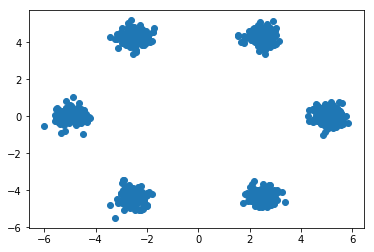

In [6]:
plt.figure()
plt.scatter([p[0] for p in things], [p[1] for p in things])
plt.show()

In [7]:
ret = None
for i in range(10000):
    ret = c.train()

In [8]:
ret[0]

5979692300000.0

In [9]:
ret[-1].shape

(64, 1)

In [10]:
ret[0].shape

()

In [11]:
ret[1].shape

(64, 1)

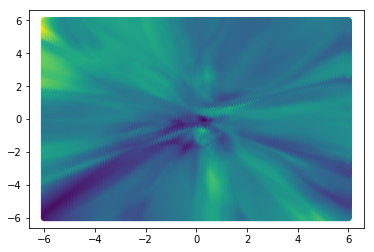

In [12]:
output_surface = c.output_surface()
b = np.max(output_surface[1])
a = np.min(output_surface[1])
y = output_surface[1]/(b - a) - a/(b - a)
plt.figure()
plt.scatter([p[0] for p in output_surface[0]], [p[1] for p in output_surface[0]], c=y[:, 0])
plt.show()

In [13]:
output_surface[1].shape

(40000, 1)